<a href="https://colab.research.google.com/github/valer1435/neurosoul-of-cyberwolf/blob/main/Pacanskie_citaty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Install env

In [ ]:
!pip3 install transformers==4.5.1
!pip install -q torch==1.4.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html

In [ ]:
!git clone  https://github.com/sberbank-ai/ru-gpts

fatal: destination path 'ru-gpts' already exists and is not an empty directory.


In [ ]:
with open("wolvescut.txt", "r") as f:
  txt = "".join(f.readlines())

txt = list(filter(lambda x: x != "\n", txt.split("\n\n\n")))
print(txt[:5])

['Самые лучшие люди — те, из-за кого ты улыбаешься чаще всего.', 'Мы поступаем так, как поступили с нами.', 'Оказывается, за счастье приходится расплачиваться слезами и острой болью в сердце…', 'Небеса знают, как для нас будет лучше, рано или поздно они сведут нас с нужными людьми и разведут с ненужными.', 'Спасибо тем кто предал. Вы сделали меня сильнее...']


In [ ]:
module_path = 'https://tfhub.dev/deepmind/biggan-deep-256/1' 

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import os
import io
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import tensorflow_hub as hub

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
tf.reset_default_graph()
print('Loading BigGAN module from:', module_path)
module = hub.Module(module_path)
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}
output = module(inputs)

print()
print('Inputs:\n', '\n'.join(
    '  {}: {}'.format(*kv) for kv in inputs.items()))
print()
print('Output:', output)

Loading BigGAN module from: https://tfhub.dev/deepmind/biggan-deep-256/1
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



Inputs:
   y: Tensor("y:0", shape=(?, 1000), dtype=float32)
  truncation: Tensor("truncation:0", shape=(), dtype=float32)
  z: Tensor("z:0", shape=(?, 128), dtype=float32)

Output: Tensor("module_apply_default/G_trunc_output:0", shape=(?, 256, 256, 3), dtype=float32)


In [ ]:
input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']

dim_z = input_z.shape.as_list()[1]
vocab_size = input_y.shape.as_list()[1]

def truncated_z_sample(batch_size, truncation=1., seed=None):
  state = None if seed is None else np.random.RandomState(seed)
  values = truncnorm.rvs(-2, 2, size=(batch_size, dim_z), random_state=state)
  return truncation * values

def one_hot(index, vocab_size=vocab_size):
  index = np.asarray(index)
  if len(index.shape) == 0:
    index = np.asarray([index])
  assert len(index.shape) == 1
  num = index.shape[0]
  output = np.zeros((num, vocab_size), dtype=np.float32)
  output[np.arange(num), index] = 1
  return output

def one_hot_if_needed(label, vocab_size=vocab_size):
  label = np.asarray(label)
  if len(label.shape) <= 1:
    label = one_hot(label, vocab_size)
  assert len(label.shape) == 2
  return label

def sample(sess, noise, label, truncation=1., batch_size=8,
           vocab_size=vocab_size):
  noise = np.asarray(noise)
  label = np.asarray(label)
  num = noise.shape[0]
  if len(label.shape) == 0:
    label = np.asarray([label] * num)
  if label.shape[0] != num:
    raise ValueError('Got # noise samples ({}) != # label samples ({})'
                     .format(noise.shape[0], label.shape[0]))
  label = one_hot_if_needed(label, vocab_size)
  ims = []
  for batch_start in range(0, num, batch_size):
    s = slice(batch_start, min(num, batch_start + batch_size))
    feed_dict = {input_z: noise[s], input_y: label[s], input_trunc: truncation}
    ims.append(sess.run(output, feed_dict=feed_dict))
  ims = np.concatenate(ims, axis=0)
  assert ims.shape[0] == num
  ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
  ims = np.uint8(ims)
  return ims

def interpolate(A, B, num_interps):
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  alphas = np.linspace(0, 1, num_interps)
  return np.array([(1-a)*A + a*B for a in alphas])

def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = N // cols + int(N % cols != 0)
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(a).save(data, format)
  im_data = data.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print(('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format))
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [ ]:
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

## Generate

In [ ]:
import numpy as np
import torch

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
def load_tokenizer_and_model(model_name_or_path):
  return GPT2Tokenizer.from_pretrained(model_name_or_path), GPT2LMHeadModel.from_pretrained(model_name_or_path).cuda()


def generate(
    model, tok, text,
    do_sample=True, max_length=50, repetition_penalty=5.0,
    top_k=5, top_p=0.95, temperature=1,
    num_beams=None,
    no_repeat_ngram_size=3
    ):
  input_ids = tok.encode(text, return_tensors="pt").cuda()
  out = model.generate(
      input_ids.cuda(),
      max_length=max_length,
      repetition_penalty=repetition_penalty,
      do_sample=do_sample,
      top_k=top_k, top_p=top_p, temperature=temperature,
      num_beams=num_beams, no_repeat_ngram_size=no_repeat_ngram_size
      )
  return list(map(tok.decode, out))

### RuGPT3Small

In [ ]:
tok, model = load_tokenizer_and_model("sberbank-ai/rugpt3small_based_on_gpt2")


Downloading:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [ ]:
import random
import re
import random

def get_wolf():
  wolves_idx = [269, 270]
  trunc = random.choice(np.arange(0, 1, 0.1))
  noise = random.choice(range(100))
  z = truncated_z_sample(1, trunc, noise)
  y = random.choice(wolves_idx)

  ims = sample(sess, z, y, truncation=trunc)
  res = imgrid(ims, cols=min(1, 5))
  imshow(res)

def gen_citation():
  zatravka = random.choice(txt)
  zatravka = " ".join(zatravka.split()[:4])
  generated = generate(model, tok, zatravka, num_beams=1)
  generated = "".join(list(filter(lambda x: x not in "@#$%^&*()+=\/|", generated[0].split("\n")[0])))
  if len(generated) - len(zatravka) < 5:
    generated = gen_citation()
  return generated

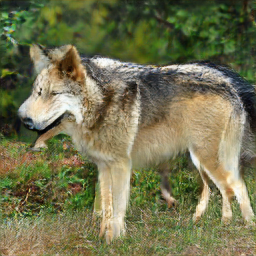

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'В этой жизни вы можете быть счастливы.  Вы любите себя, а также своих детей и мужа; вас не интересует ваша карьера или работа в офисе – все это второстепенно для Вас! '

In [ ]:
get_wolf()
gen_citation()